# SVD w/Normalizer 

### Importing Libraries

In [1]:
from keras import backend as K
from keras import regularizers
import nregularizer
import numpy as np
from gensim_download import pickle_rw
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import plotly.plotly as py
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy.linalg

from numpy.linalg import det

from numpy.linalg import inv

import sympy as sympy

import pandas as pd
%matplotlib inline
import seaborn as sns; sns.set()

from sympy import Matrix
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot



Using TensorFlow backend.


### Defining Functions

In [2]:
def make_dict(vocab, vectors):
    """Make dictionary of vocab and vectors"""
    return {vocab[i]: vectors[i] for i in range(len(vocab))}


def vocab_train_test(embedding, lg1, lg2, lg1_vocab):
    """Create training and test vocabularies"""
    if embedding == 'zeroshot':
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_train_5K.txt') as f:
            vocab_train = [(_.split(' ')[0], _.split(' ')[1])
                           for _ in f.read().split('\n')[:-1]]
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_test.txt') as f:
            vocab_test = [(_.split(' ')[0], _.split(' ')[1])
                          for _ in f.read().split('\n')[:-1]]

    elif embedding in ['fasttext_random', 'fasttext_top']:
        embedding, split = embedding.split('_')
        lg1_lg2, lg2_lg1 = pickle_rw((lg1 + '_' + lg2, 0),
                                     (lg2 + '_' + lg1, 0), write=False)
        # T = Translation, R = Reverse (translated and then translated back)
        # Create vocab from 2D translations
        vocab_2D = []
        for lg1_word in lg1_vocab:
            # Translate lg1_word
            if lg1_word in lg1_lg2:
                lg1_word_T = lg1_lg2[lg1_word]
                # Check if translated word (or lowercase) is in lg2_lg1
                if lg1_word_T in lg2_lg1.keys():
                    lg1_word_R = lg2_lg1[lg1_word_T]
                elif lg1_word_T.lower() in lg2_lg1.keys():
                    lg1_word_T = lg1_word_T.lower()
                    lg1_word_R = lg2_lg1[lg1_word_T]
                else:
                    lg1_word_R = None

                # Check if lg1_word and lg1_word_R are equal (lowercase)
                if lg1_word_R:
#                     if lg1_word.lower() == lg1_word_R.lower():
                    vocab_2D.append((lg1_word, lg1_word_T))
        print('length of '+ lg1+'-'+ lg2+ ' vocab: '+str(len(vocab_2D)))

        #Create Train/Test vocab

        if split == 'random':
            sample = np.random.choice(len(vocab_2D), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[sample[:5000]].tolist()
            vocab_test = np.asarray(vocab_2D)[sample[5000:]].tolist()
        elif split == 'top':
            sample = np.random.choice(range(6500), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[:5000, :].tolist()
            vocab_test = np.asarray(vocab_2D)[:1500, :].tolist()
        else:
            pass

        # if split == 'random':
        #     sample = np.random.choice(len(vocab_2D), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[sample[:700]].tolist()
        #     vocab_test = np.asarray(vocab_2D)[sample[700:]].tolist()
        # elif split == 'top':
        #     sample = np.random.choice(range(900), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[:700, :].tolist()
        #     vocab_test = np.asarray(vocab_2D)[:200, :].tolist()
        # else:
        #     pass

    return vocab_train, vocab_test


def vectors_train_test(vocab_train, vocab_test):
    """Create training and test vectors"""
    X_train, y_train = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                             for lg1_word, lg2_word in vocab_train])
    X_test, y_test = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                           for lg1_word, lg2_word in vocab_test])
    return map(np.asarray, (X_train, X_test, y_train, y_test))




def translation_matrix(X_train, y_train):
    """Fit translation matrix T"""
    #def norm_reg(weight_matrix):
     #   return 0.01 * np.linalg.norm(np.matrix(np.subtract(np.matmul(weight_matrix,weight_matrix.T,np.matmul(weight_matrix.T,weight_matrix))),'fro')
    model = Sequential()
    model.add(Dense(300, use_bias=False, input_shape=(X_train.shape[1],),kernel_regularizer=nregularizer.l3(0.000001)))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                        verbose=False)
    T = model.get_weights()[0]

    T = np.matrix(T)

    M = np.multiply(np.matrix(T),100)

    T_norm, T_normed = normalize(M)

    D = np.linalg.det(M)
    
    I = inv(T)
    
    Fr_norm = np.linalg.norm(np.matrix(np.subtract(np.matmul(T,T.getH()),np.matmul(T.getH(),T))),'fro')

    print ("Determinant:"+str(D))
    
    print ("Fr_norm:"+str(Fr_norm))

    if np.array_equal(np.around(np.matmul(T_normed,T_normed.getH())), np.around(np.matmul(T_normed.getH(),T_normed))) == True:
        tf = "True"
    else:
        tf = "False"

    return model, history, T, D, tf, I, M

def translation_accuracy(X_test, y_test):
    """Get predicted matrix 'yhat' using 'T' and find translation accuracy"""
    # yhat
    yhat = X.dot(T)
    count = 0
    for i in range(len(y_test)):
        if yhat[i,:].all() == y_test[i,:].all():
            count = count + 1
    accuracy = count/len(y_test)*100
    return accuracy

def svd(T):
    """Perform SVD on the translation matrix 'T' """
    U, s, Vh = numpy.linalg.svd(T, full_matrices=False )
    return U, s, Vh

def T_svd_EDA(s):
    """Perform SVD on the translation matrix 'T' """
    plt.hist(s, bins='auto', range = (0,1),normed = 1)
    plt.show()




def normalize(matrix):
    """Normalize the rows of a matrix"""
    matrix_norm = np.linalg.norm(matrix, axis=1)
    matrix_normed = matrix / np.repeat(matrix_norm, matrix.shape[1]). \
        reshape(matrix.shape)
    return matrix_norm, matrix_normed


def translation_results(X, y, vocab, M, lg2_vectors, lg2_vocab):
    """X, y, vocab - The training or test data that you want results for
    T - The translation matrix
    lg2_vectors, lg2_vocab - Foreign language used to find the nearest neighbor
    """

    # Data Prep on Inputs
    X_word, y_word = zip(*vocab)
    X_norm, X_normed = normalize(X)
    y_norm, y_normed = normalize(y)
    lg2_vectors_norm, lg2_vectors_normed = normalize(lg2_vectors)

    # yhat
    yhat = X.dot(M)
    yhat_norm, yhat_normed = normalize(yhat)

    #X_norm = normalize(X)


    # Nearest Neighbors
    neg_cosine = -yhat_normed.dot(lg2_vectors_normed.T)
    ranked_neighbor_indices = np.argsort(neg_cosine, axis=1)

    # Nearest Neighbor
    nearest_neighbor_indices = ranked_neighbor_indices[:, 0]
    yhat_neighbor = lg2_vectors[nearest_neighbor_indices, :]
    yhat_neighbor_norm, yhat_neighbor_normed = normalize(yhat_neighbor)
    yhat_neighbor_word = np.asarray(lg2_vocab)[nearest_neighbor_indices]

    # Results DF
    cols = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm',
            'X_word', 'y_word', 'yhat_neighbor_word']
    results_df = pd.DataFrame({'X_norm': X_norm,
                               'y_norm': y_norm,
                               'yhat_norm': yhat_norm,
                               'yhat_neighbor_norm': yhat_neighbor_norm,
                               'X_word': X_word,
                               'y_word': y_word,
                               'yhat_neighbor_word': yhat_neighbor_word,})
    results_df = results_df[cols]
    results_df['neighbor_correct'] = results_df.y_word == \
        results_df.yhat_neighbor_word

    return yhat_norm


def T_norm_EDA(results_df):
    """Plot result norms side-by-side"""
    test_size = results_df.shape[0]
    test_accuracy = round(results_df.neighbor_correct.mean(), 2)

    print('Test Accuracy: '+str(test_accuracy)+'\n')

    plot_data = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm']
    # f, ax = plt.subplots(len(plot_data), sharex=True, sharey=True,
    #                      figsize=(10, 10))
    # for i, d in enumerate(plot_data):
    #     ax[i].hist(results_df[d], bins=100)
    #     ax[i].axis('off')
    #     title = '{}: mean={}, std={}'.format(d, round(results_df[d].mean(), 2), round(results_df[d].std(), 2))
    #     ax[i].set_title(title)
    # f.subplots_adjust(hspace=0.7)
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_norm.png')
    # plt.close('all')
    return


def T_pca_EDA(T):
    """PCA on matrix T"""
    T_ss = StandardScaler().fit_transform(T)
    pca = PCA().fit(T_ss)
    n = pca.n_components_

    # plt.figure(figsize=(10, 6))
    # plt.xlim((0, n))
    # plt.ylim((0, 1))
    # plt.plot(range(n + 1), [0] + np.cumsum(pca.explained_variance_ratio_).
    #          tolist())
    # plt.plot(range(n + 1), np.asarray(range(n + 1)) / n)
    # plt.xlabel('Number of Eigenvectors')
    # plt.ylabel('Explained Variance')
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_isotropy.png')
    # plt.close('all')

    isotropy = (1 - sum(np.cumsum(pca.explained_variance_ratio_) * 1 / n)) / .5
    return isotropy


def T_report_results(embedding, lg1, lg2, lg1_vectors, lg2_vectors,
                     X_train, X_test, D, results_df, isotropy):
    md = '## ' + lg1.title() + ' to ' + lg2.title() + ' ' + \
        embedding.title() + '  \n'
    md += '- ' + lg1.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[0]) + '  \n'
    md += '- ' + lg1.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[1]) + '  \n'
    md += '- ' + lg2.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[0]) + '  \n'
    md += '- ' + lg2.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[1]) + '  \n'
    md += '- Train Size = ' + '{:,.0f}'.format(X_train.shape[0]) + '  \n'
    md += '- Test Size = ' + '{:,.0f}'.format(X_test.shape[0]) + '  \n'
    md += '- Determinant = ' + '{:,.0f}'.format(D) + '  \n'

    md += '- <b>Test Accuracy = ' + \
        '{:,.1%}'.format(results_df.neighbor_correct.mean()) + '</b>  \n\n'



    md += '#### Test L2 Norms  \n'
    md += '- X_norm: L2 norms for ' + lg1.title() + ' test vectors  \n'
    md += '- y_norm: L2 norms for ' + lg2.title() + ' test vectors  \n'
    md += '- yhat_norm: L2 norms for X.dot(T) test vectors ' + \
        '(T = translation matrix)  \n'
    md += '- yhat_neighbor norm: L2 norms for nearest neighbor' + \
        'to X.dot(T) in y test vectors  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_norm.png)  \n\n'

    md += '#### Translation Matrix Isotropy  \n'
    md += '- Isotropy = ' + '{:,.1%}'.format(isotropy) + '  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_isotropy.png)  \n\n'

    return md

### Main Function ( with SVD stats )

In [9]:
if __name__ == '__main__':
    # Manually set list of translations (embedding, lg1, lg2)
    translations = [#('fasttext_random', 'en', 'ru'),
                    ('fasttext_top', 'en', 'en'),
                    ('fasttext_top', 'en', 'ru'),
                    #('fasttext_random', 'en', 'de'),
                    ('fasttext_top', 'en', 'de'),
                    #('fasttext_random', 'en', 'es'),
                    ('fasttext_top', 'en', 'es'),
                    ('fasttext_top', 'en', 'fr'),
                    ('fasttext_top', 'en', 'it'),
                    #('fasttext_random', 'en', 'zh-CN'),
                    ('fasttext_top', 'en', 'zh-CN'),
               
        
        
                     #('fasttext_random', 'ru', 'en'),
                    ('fasttext_top', 'ru', 'en'),
                    #('fasttext_random', 'ru', 'es'),
                    ('fasttext_top', 'ru', 'ru'),
                    ('fasttext_top', 'ru', 'de'),
                    ('fasttext_top', 'ru', 'es'),
                    ('fasttext_top', 'ru', 'fr'),
                    ('fasttext_top', 'ru', 'it'),
                    #('fasttext_random', 'ru', 'zh-CN'),
                    ('fasttext_top', 'ru', 'zh-CN'),
                    #('fasttext_random', 'ru', 'de'),
                   
                    
        
        
                    #('fasttext_random', 'de', 'en'),
                    ('fasttext_top', 'de', 'en'),
                    #('fasttext_random', 'de', 'es'),
                    ('fasttext_top', 'de', 'ru'), 
                    #('fasttext_random', 'de', 'ru'),
                    ('fasttext_top', 'de', 'de'),
                    ('fasttext_top', 'de', 'es'),
                    ('fasttext_top', 'de', 'fr'),
                    ('fasttext_top', 'de', 'it'),
                    #('fasttext_random', 'de', 'zh-CN'),
                    ('fasttext_top', 'de', 'zh-CN'),
            
        
        
                    #('fasttext_random', 'es', 'en'),
                    ('fasttext_top', 'es', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'es', 'ru'),
                    ('fasttext_top', 'es', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'es', 'es'),
                    ('fasttext_top', 'es', 'fr'),
                    ('fasttext_top', 'es', 'it'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'es', 'zh-CN'),
      
        
        
        
                    ('fasttext_top', 'fr', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'fr', 'ru'),
                    ('fasttext_top', 'fr', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'fr', 'es'),
                    ('fasttext_top', 'fr', 'fr'),
                    ('fasttext_top', 'fr', 'it'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'fr', 'zh-CN'),
              
        
                    ('fasttext_top', 'it', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'it', 'ru'),
                    ('fasttext_top', 'it', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'it', 'es'),
                    ('fasttext_top', 'it', 'fr'),
                    ('fasttext_top', 'it', 'it'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'it', 'zh-CN'),
              
        
        
        
                    #('fasttext_random', 'zh-CN', 'en'),
                    ('fasttext_top', 'zh-CN', 'en'),
                    #('fasttext_random', 'zh-CN', 'es'),
                    ('fasttext_top', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'de'),
                    ('fasttext_top', 'zh-CN', 'es'),
                    ('fasttext_top', 'zh-CN', 'fr'),
                    ('fasttext_top', 'zh-CN', 'it'),
                    #('fasttext_random', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'zh-CN')
                    #('fasttext_random', 'zh-CN', 'de'),
           
        
                   

                    ]
   
    s_min_en=[]
    s_max_en=[]
    s_mean_en=[]
    s_median_en=[]
    s_std_en=[]
            
    s1_min_en=[]
    s1_max_en=[]
    s1_mean_en=[]
    s1_median_en=[]
    s1_std_en=[]
        
       
        
    s_min_es=[]
    s_max_es=[]
    s_mean_es=[]
    s_median_es=[]
    s_std_es=[]
            
    s1_min_es=[]
    s1_max_es=[]
    s1_mean_es=[]
    s1_median_es=[]
    s1_std_es=[]
     
        
    s_min_fr=[]
    s_max_fr=[]
    s_mean_fr=[]
    s_median_fr=[]
    s_std_fr=[]
            
    s1_min_fr=[]
    s1_max_fr=[]
    s1_mean_fr=[]
    s1_median_fr=[]
    s1_std_fr=[]    
       
    s_min_ru=[]
    s_max_ru=[]
    s_mean_ru=[]
    s_median_ru=[]
    s_std_ru=[]
            
    s1_min_ru=[]
    s1_max_ru=[]
    s1_mean_ru=[]
    s1_median_ru=[]
    s1_std_ru=[]
            
       
        
    s_min_de=[]
    s_max_de=[]
    s_mean_de=[]
    s_median_de=[]
    s_std_de=[]
        
    s1_min_de=[]
    s1_max_de=[]
    s1_mean_de=[]
    s1_median_de=[]
    s1_std_de=[]
        
      
        
    s_min_zh=[]
    s_max_zh=[]
    s_mean_zh=[]
    s_median_zh=[]
    s_std_zh=[]
            
    s1_min_zh=[]
    s1_max_zh=[]
    s1_mean_zh=[]
    s1_median_zh=[]
    s1_std_zh=[]

    
    s_min_it=[]
    s_max_it=[]
    s_mean_it=[]
    s_median_it=[]
    s_std_it=[]
            
    s1_min_it=[]
    s1_max_it=[]
    s1_mean_it=[]
    s1_median_it=[]
    s1_std_it=[]

    
    md = ''
    for translation in translations:
        embedding, lg1, lg2 = translation
        # Vocab/Vectors/Dicts
        lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
            pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      write=False)
        lg1_dict = make_dict(lg1_vocab, lg1_vectors)
        lg2_dict = make_dict(lg2_vocab, lg2_vectors)

        print('Translation: '+lg1+'->'+lg2+'\n')

        # Train/Test Vocab/Vectors
        vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
        X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                              vocab_test)
 
        
        # Fit tranlation matrix to training data
        model, history, T, D, tf,I, M = translation_matrix(X_train, y_train)

        print('biggest element:'+str(np.max(T))+'\n')
        
        U,s,Vh = svd(T*T)
        
        #scaler = MinMaxScaler()
        
        #scaler.fit(s)
        
        #s = scaler.transform(s)
        
        s1 = np.log10(s)
        
        print("min: "+str(min(s))+"\n")
        
        print("max: "+str(max(s))+"\n")
        
        print("mean: "+str(np.mean(s))+"\n")
        
        print("median: "+str(np.median(s))+"\n")
        
        print("std: "+str(np.std(s))+"\n")
        
        
        
        print("min: "+str(min(s1))+"\n")
        
        print("max: "+str(max(s1))+"\n")
        
        print("mean: "+str(np.mean(s1))+"\n")
        
        print("median: "+str(np.median(s1))+"\n")
        
        print("std: "+str(np.std(s1))+"\n")
        
        
        if lg1 == 'en':
            s_min_en.append(min(s))
            s_max_en.append(max(s))
            s_mean_en.append(np.mean(s))
            s_median_en.append(np.median(s))
            s_std_en.append(np.std(s))
            
            s1_min_en.append(min(s1))
            s1_max_en.append(max(s1))
            s1_mean_en.append(np.mean(s1))
            s1_median_en.append(np.median(s1))
            s1_std_en.append(np.std(s1))
        
        if lg1 == 'es':
        
            s_min_es.append(min(s))
            s_max_es.append(max(s))
            s_mean_es.append(np.mean(s))
            s_median_es.append(np.median(s))
            s_std_es.append(np.std(s))
            
            s1_min_es.append(min(s1))
            s1_max_es.append(max(s1))
            s1_mean_es.append(np.mean(s1))
            s1_median_es.append(np.median(s1))
            s1_std_es.append(np.std(s1))
            
        if lg1 == 'ru':
        
            s_min_ru.append(min(s))
            s_max_ru.append(max(s))
            s_mean_ru.append(np.mean(s))
            s_median_ru.append(np.median(s))
            s_std_ru.append(np.std(s))
            
            s1_min_ru.append(min(s1))
            s1_max_ru.append(max(s1))
            s1_mean_ru.append(np.mean(s1))
            s1_median_ru.append(np.median(s1))
            s1_std_ru.append(np.std(s1))
            
        if lg1 == 'de':
        
            s_min_de.append(min(s))
            s_max_de.append(max(s))
            s_mean_de.append(np.mean(s))
            s_median_de.append(np.median(s))
            s_std_de.append(np.std(s))
            
            s1_min_de.append(min(s1))
            s1_max_de.append(max(s1))
            s1_mean_de.append(np.mean(s1))
            s1_median_de.append(np.median(s1))
            s1_std_de.append(np.std(s1))
       
        if lg1 == 'fr':
        
            s_min_fr.append(min(s))
            s_max_fr.append(max(s))
            s_mean_fr.append(np.mean(s))
            s_median_fr.append(np.median(s))
            s_std_fr.append(np.std(s))
            
            s1_min_fr.append(min(s1))
            s1_max_fr.append(max(s1))
            s1_mean_fr.append(np.mean(s1))
            s1_median_fr.append(np.median(s1))
            s1_std_fr.append(np.std(s1))
    
        if lg1 == 'zh-CN':
        
            s_min_zh.append(min(s))
            s_max_zh.append(max(s))
            s_mean_zh.append(np.mean(s))
            s_median_zh.append(np.median(s))
            s_std_zh.append(np.std(s))
            
            s1_min_zh.append(min(s1))
            s1_max_zh.append(max(s1))
            s1_mean_zh.append(np.mean(s1))
            s1_median_zh.append(np.median(s1))
            s1_std_zh.append(np.std(s1))
    
        if lg1 == 'it':
        
            s_min_it.append(min(s))
            s_max_it.append(max(s))
            s_mean_it.append(np.mean(s))
            s_median_it.append(np.median(s))
            s_std_it.append(np.std(s))
            
            s1_min_it.append(min(s1))
            s1_max_it.append(max(s1))
            s1_mean_it.append(np.mean(s1))
            s1_median_it.append(np.median(s1))
            s1_std_it.append(np.std(s1))
      
        
        
        
        
#         #print(s)
        
#         plt.hist(s,bins='auto')#bins=50,normed='True',range = (0.0,0.2))
#         #plt.plot(s)
#         plt.show()
        
        

Translation: it->en

length of it-en vocab: 6532


/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning:

overflow encountered in det



Determinant:-inf
Fr_norm:6.7528
biggest element:0.135798

min: 9.96125e-06

max: 0.759494

mean: 0.219149

median: 0.173723

std: 0.187113

min: -5.00169

max: -0.119476

mean: -0.968525

median: -0.760145

std: 0.729453

Translation: it->ru

length of it-ru vocab: 4455
Determinant:-inf
Fr_norm:8.95003
biggest element:0.123625

min: 4.92341e-06

max: 1.00616

mean: 0.194867

median: 0.120043

std: 0.208301

min: -5.30773

max: 0.00266819

mean: -1.10931

median: -0.920672

std: 0.800162

Translation: it->de

length of it-de vocab: 10582
Determinant:inf
Fr_norm:8.14623
biggest element:0.135017

min: 9.20688e-06

max: 0.917944

mean: 0.206558

median: 0.13448

std: 0.207372

min: -5.03589

max: -0.0371838

mean: -1.07543

median: -0.871367

std: 0.806117

Translation: it->es

length of it-es vocab: 5891
Determinant:inf
Fr_norm:7.2078
biggest element:0.141641

min: 2.04185e-05

max: 0.789759

mean: 0.214793

median: 0.162205

std: 0.190198

min: -4.68998

max: -0.102506

mean: -0.984311



## Making List of Lists

In [10]:
s_min = []
s_min.append(s_min_en)
s_min.append(s_min_ru)
s_min.append(s_min_de)
s_min.append(s_min_es)
s_min.append(s_min_fr)
s_min.append(s_min_it)
s_min.append(s_min_zh)

s_max = []
s_max.append(s_max_en)
s_max.append(s_max_ru)
s_max.append(s_max_de)
s_max.append(s_max_es)
s_max.append(s_max_fr)
s_max.append(s_min_it)
s_max.append(s_max_zh)

s_mean = []
s_mean.append(s_mean_en)
s_mean.append(s_mean_ru)
s_mean.append(s_mean_de)
s_mean.append(s_mean_es)
s_mean.append(s_mean_fr)
s_mean.append(s_mean_it)
s_mean.append(s_mean_zh)

s_median = []
s_median.append(s_median_en)
s_median.append(s_median_ru)
s_median.append(s_median_de)    
s_median.append(s_median_es)
s_median.append(s_median_fr)
s_median.append(s_median_it)
s_median.append(s_median_zh)

s_std = []
s_std.append(s_std_en)
s_std.append(s_std_ru)
s_std.append(s_std_de)
s_std.append(s_std_es)
s_std.append(s_std_fr)
s_std.append(s_std_it)
s_std.append(s_std_zh)


s1_min = []
s1_min.append(s1_min_en)
s1_min.append(s1_min_ru)
s1_min.append(s1_min_de)
s1_min.append(s1_min_es)
s1_min.append(s1_min_fr)
s1_min.append(s1_min_it)
s1_min.append(s1_min_zh)

s1_max = []
s1_max.append(s1_max_en)
s1_max.append(s1_max_ru)
s1_max.append(s1_max_de)
s1_max.append(s1_max_es)
s1_max.append(s1_max_fr)
s1_max.append(s1_max_it)
s1_max.append(s1_max_zh)

s1_mean = []
s1_mean.append(s1_mean_en)
s1_mean.append(s1_mean_ru)
s1_mean.append(s1_mean_de)
s1_mean.append(s1_mean_es)
s1_mean.append(s1_mean_fr)
s1_mean.append(s1_mean_it)
s1_mean.append(s1_mean_zh)

s1_median = []
s1_median.append(s1_median_en)
s1_median.append(s1_median_ru)
s1_median.append(s1_median_de)
s1_median.append(s1_median_es)
s1_median.append(s1_median_fr)
s1_median.append(s1_median_it)
s1_median.append(s1_median_zh)

s1_std = []
s1_std.append(s1_std_en)
s1_std.append(s1_std_ru)
s1_std.append(s1_std_de)
s1_std.append(s1_std_es)
s1_std.append(s1_std_fr)
s1_std.append(s1_std_it)
s1_std.append(s1_std_zh)

    

## Converting List of Lists to Pandas DF

In [11]:
#s_min_df = pd.DataFrame(s_min)
#s_min_df.columns =['en', 'ru', 'de', 'es', 'zh-CN']
s_min_df =pd.DataFrame(s_min,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s_max_df =pd.DataFrame(s_max,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s_mean_df =pd.DataFrame(s_mean,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s_median_df =pd.DataFrame(s_median,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s_std_df =pd.DataFrame(s_std,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])


s1_min_df =pd.DataFrame(s1_min,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s1_max_df =pd.DataFrame(s1_max,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s1_mean_df =pd.DataFrame(s1_mean,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s1_median_df =pd.DataFrame(s1_median,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])
s1_std_df =pd.DataFrame(s1_std,index = ['en', 'ru', 'de', 'es', 'fr','it','zh-CN',], columns =['en', 'ru', 'de', 'es','fr','it', 'zh-CN'])



In [12]:
s_min_df = np.transpose(s_min_df)
s_max_df = np.transpose(s_max_df)
s_mean_df = np.transpose(s_mean_df)
s_median_df = np.transpose(s_median_df)
s_std_df = np.transpose(s_std_df)


s1_min_df = np.transpose(s1_min_df)
s1_max_df = np.transpose(s1_max_df)
s1_mean_df = np.transpose(s1_mean_df)
s1_median_df = np.transpose(s1_median_df)
s1_std_df = np.transpose(s1_std_df)


In [13]:
cmap = sns.diverging_palette(10, 130, sep=20, as_cmap=True)


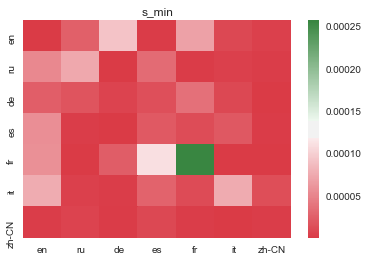

In [14]:
s_min_hm = sns.heatmap(s_min_df,cmap=cmap)
title = s_min_hm.set_title('s_min')

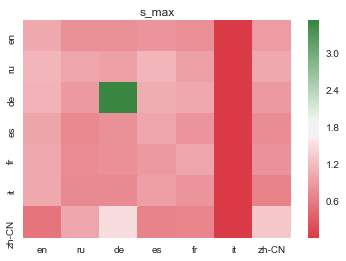

In [15]:
s_max_hm = sns.heatmap(s_max_df,cmap=cmap)
title = s_max_hm.set_title('s_max')

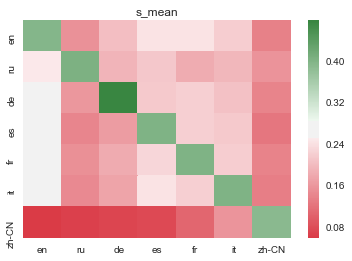

In [16]:
s_mean_hm = sns.heatmap(s_mean_df,cmap=cmap)
title = s_mean_hm.set_title('s_mean')

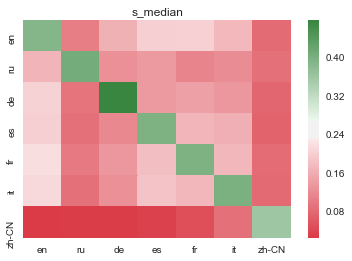

In [17]:
s_median_hm = sns.heatmap(s_median_df,cmap=cmap)
title = s_median_hm.set_title('s_median')

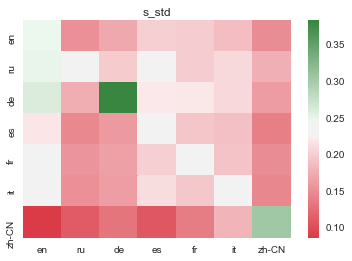

In [18]:
s_std_hm = sns.heatmap(s_std_df,cmap=cmap)
title = s_std_hm.set_title('s_std')

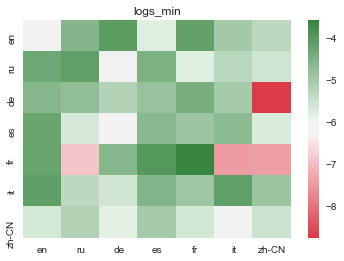

In [19]:
s1_min_hm = sns.heatmap(s1_min_df,cmap=cmap)
title = s1_min_hm.set_title('logs_min')

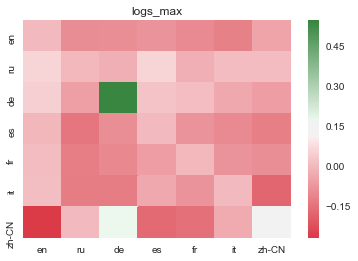

In [20]:
s1_max_hm = sns.heatmap(s1_max_df,cmap=cmap)
title = s1_max_hm.set_title('logs_max')

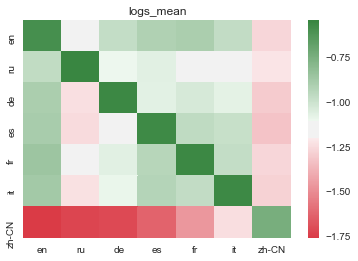

In [21]:
s1_mean_hm = sns.heatmap(s1_mean_df,cmap=cmap)
title = s1_mean_hm.set_title('logs_mean')

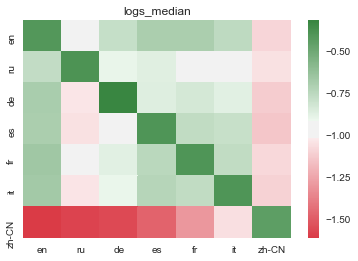

In [22]:
s1_median_hm = sns.heatmap(s1_median_df,cmap=cmap)
title = s1_median_hm.set_title('logs_median')

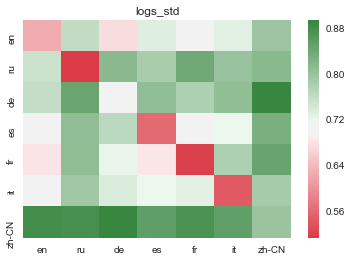

In [23]:
s1_std_hm = sns.heatmap(s1_std_df,cmap=cmap)
title = s1_std_hm.set_title('logs_std')